In [ ]:
pip install pycox

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import pandas as pd

import torch
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [ ]:
csv = pd.read_csv('/content/all-in-one.csv')
test_csv = pd.read_csv('/content/test-data.csv')

In [ ]:
df_untreated_train = csv[csv.Treatment == 0]
df_treated_train = csv[csv.Treatment == 1]

In [ ]:
df_untreated_test = df_untreated_train.sample(frac=0.2)
df_untreated_train = df_untreated_train.drop(df_untreated_test.index)
df_untreated_val = df_untreated_train.sample(frac=0.2)
df_untreated_train = df_untreated_train.drop(df_untreated_val.index)

df_treated_test = df_treated_train.sample(frac=0.2)
df_treated_train = df_treated_train.drop(df_treated_test.index)
df_treated_val = df_treated_train.sample(frac=0.2)
df_treated_train = df_treated_train.drop(df_treated_val.index)

In [ ]:
cols_standardize = ['Var' + str(i) for i in range(1,11)]
cols_leave = ['G' + str(i) for i in range(1,301)]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
x_untreated_train = x_mapper.fit_transform(df_untreated_train).astype('float32')
x_untreated_val = x_mapper.transform(df_untreated_val).astype('float32')
x_untreated_test = x_mapper.transform(df_untreated_test).astype('float32')

x_treated_train = x_mapper.fit_transform(df_treated_train).astype('float32')
x_treated_val = x_mapper.transform(df_treated_val).astype('float32')
x_treated_test = x_mapper.transform(df_treated_test).astype('float32')

In [ ]:
x_mapper_gene = [(col, None) for col in ['G' + str(i) for i in range(1,301)] +  ['Var' + str(i) for i in range(1,11)]]
x_gene = x_mapper.transform(test_csv).astype('float32')

In [ ]:
print(df_treated_test)

     G1  G2  G3  G4  G5  G6  ...  Var8  Var9  Var10        time  event  Treatment
174   0   0   0   0   0   0  ...     1     2      0   68.820951      1          1
41    0   0   0   0   1   0  ...     5     1      2   43.478232      1          1
873   0   0   0   1   0   1  ...     3     3      2  101.567678      1          1
704   0   0   0   0   0   0  ...     1     2      0   42.712902      1          1
680   0   0   0   0   0   0  ...     4     2      2   55.413826      1          1
..   ..  ..  ..  ..  ..  ..  ...   ...   ...    ...         ...    ...        ...
321   0   0   0   0   0   0  ...     2     3      6   28.407132      1          1
646   0   0   0   0   0   0  ...     2     0      0   57.786192      1          1
906   0   0   0   0   0   0  ...     5     2      2   44.197178      1          1
91    0   0   0   0   0   0  ...     2     1      2   34.073270      1          1
480   0   0   0   0   0   0  ...     2     5      5   65.661130      1          1

[98 rows x 313 

In [ ]:
print(test_csv)

     G1  G2  G3  G4  G5  G6  ...  Var8  Var9  Var10  time  event  Treatment
0     0   0   0   0   0   0  ...     0     0      0     0      0          0
1     1   0   0   0   0   0  ...     0     0      0     0      0          0
2     0   1   0   0   0   0  ...     0     0      0     0      0          0
3     0   0   1   0   0   0  ...     0     0      0     0      0          0
4     0   0   0   1   0   0  ...     0     0      0     0      0          0
..   ..  ..  ..  ..  ..  ..  ...   ...   ...    ...   ...    ...        ...
296   0   0   0   0   0   0  ...     0     0      0     0      0          0
297   0   0   0   0   0   0  ...     0     0      0     0      0          0
298   0   0   0   0   0   0  ...     0     0      0     0      0          0
299   0   0   0   0   0   0  ...     0     0      0     0      0          0
300   0   0   0   0   0   0  ...     0     0      0     0      0          0

[301 rows x 313 columns]


In [ ]:
get_target = lambda df: (df['time'].values, df['event'].values)
y_untreated_train = get_target(df_untreated_train)
y_untreated_val = get_target(df_untreated_val)


y_treated_train = get_target(df_treated_train)
y_treated_val = get_target(df_treated_val)

untreated_durations_test, untreated_events_test = get_target(df_untreated_test)
untreated_val = x_untreated_val, y_untreated_val

treated_durations_test, treated_events_test = get_target(df_treated_test)
treated_val = x_treated_val, y_treated_val

In [ ]:
in_features = x_treated_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = torch.nn.Sequential(
    torch.nn.Linear(in_features, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),

    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),

    
    torch.nn.Linear(32, out_features)
)

net2 = torch.nn.Sequential(
    torch.nn.Linear(in_features, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),

    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),

    
    torch.nn.Linear(32, out_features)
)

In [ ]:
model = CoxPH(net, tt.optim.Adam)

In [ ]:
model2 = CoxPH(net2, tt.optim.Adam)

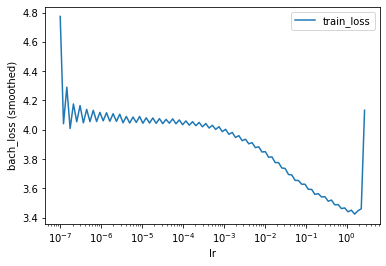

In [ ]:
batch_size = 256
lrfinder = model.lr_finder(x_treated_train, y_treated_train, batch_size, tolerance=10)
_ = lrfinder.plot()

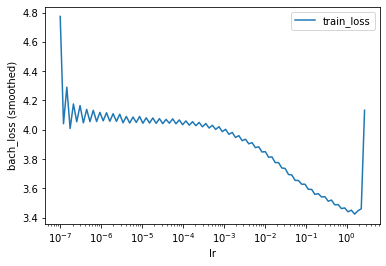

In [ ]:
batch_size = 256
lrfinder2 = model.lr_finder(x_untreated_train, y_untreated_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [ ]:
lrfinder.get_best_lr()

0.15556761439304817

In [ ]:
lrfinder2.get_best_lr()

0.10722672220103299

In [ ]:
model.optimizer.set_lr(lrfinder.get_best_lr())

In [ ]:
model2.optimizer.set_lr(lrfinder2.get_best_lr())

In [ ]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [ ]:
%%time
log = model.fit(x_treated_train, y_treated_train, batch_size, epochs, callbacks, verbose,
                val_data=treated_val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.1074,	val_loss: 4.4300
1:	[0s / 0s],		train_loss: 4.8703,	val_loss: 8.3895
2:	[0s / 0s],		train_loss: 3.8443,	val_loss: 13.5242
3:	[0s / 0s],		train_loss: 3.9070,	val_loss: 8.9190
4:	[0s / 0s],		train_loss: 3.7079,	val_loss: 4.4596
5:	[0s / 0s],		train_loss: 3.6062,	val_loss: 3.6616
6:	[0s / 0s],		train_loss: 3.5530,	val_loss: 4.2023
7:	[0s / 0s],		train_loss: 3.5527,	val_loss: 5.3472
8:	[0s / 0s],		train_loss: 3.4967,	val_loss: 5.3833
9:	[0s / 0s],		train_loss: 3.4809,	val_loss: 4.3735
10:	[0s / 0s],		train_loss: 3.3867,	val_loss: 3.8541
11:	[0s / 0s],		train_loss: 3.3832,	val_loss: 3.6626
12:	[0s / 0s],		train_loss: 3.3678,	val_loss: 3.6017
13:	[0s / 0s],		train_loss: 3.1603,	val_loss: 3.7292
14:	[0s / 0s],		train_loss: 3.2351,	val_loss: 3.9595
15:	[0s / 0s],		train_loss: 3.2500,	val_loss: 3.8767
16:	[0s / 0s],		train_loss: 2.9274,	val_loss: 3.7796
17:	[0s / 0s],		train_loss: 3.1210,	val_loss: 3.8501
18:	[0s / 0s],		train_loss: 3.0229,	val_loss: 3.8725
19

In [ ]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True


In [ ]:

%%time
log = model2.fit(x_untreated_train, y_untreated_train, batch_size, epochs, callbacks, verbose,
                val_data=untreated_val, val_batch_size=batch_size)

1:	[0s / 0s],		train_loss: 3.9651,	val_loss: 3.3986
2:	[0s / 0s],		train_loss: 3.9068,	val_loss: 3.3063
3:	[0s / 0s],		train_loss: 3.5982,	val_loss: 4.9070
4:	[0s / 0s],		train_loss: 3.6684,	val_loss: 5.9344
5:	[0s / 0s],		train_loss: 3.5707,	val_loss: 4.5405
6:	[0s / 0s],		train_loss: 3.4450,	val_loss: 4.4357
7:	[0s / 0s],		train_loss: 3.4256,	val_loss: 5.6454
8:	[0s / 0s],		train_loss: 3.5886,	val_loss: 5.3954
9:	[0s / 0s],		train_loss: 3.3149,	val_loss: 4.2609
10:	[0s / 0s],		train_loss: 3.3003,	val_loss: 3.8291
11:	[0s / 0s],		train_loss: 3.3107,	val_loss: 3.7234
12:	[0s / 0s],		train_loss: 3.2050,	val_loss: 3.7377
CPU times: user 133 ms, sys: 4.57 ms, total: 137 ms
Wall time: 139 ms


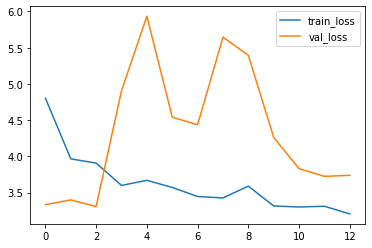

In [ ]:
_ = log.plot()

In [ ]:
_

In [ ]:
_ = model.compute_baseline_hazards()

In [ ]:
_ = model2.compute_baseline_hazards()

In [ ]:
model.baseline_hazards_

duration
7.070708           0.000000
9.843261           0.000000
11.274018          0.000000
11.442581          0.000000
19.308586          0.000000
                  ...      
130.121877        65.765831
135.736399        65.774037
137.888591        65.864175
138.861338       344.760052
217.078908    175056.576792
Name: baseline_hazards, Length: 312, dtype: float64

In [ ]:
model2.baseline_hazards_

duration
17.640615     0.000000e+00
22.874687     8.107236e-03
23.102221     8.134659e-03
23.187958     8.152619e-03
23.247105     8.182087e-03
                  ...     
94.897598     1.542945e+01
96.098117     0.000000e+00
97.761355     4.436976e+02
106.444390    8.348120e+02
133.364200    7.871239e+06
Name: baseline_hazards, Length: 327, dtype: float64

In [ ]:
len(x_gene)

301

In [ ]:
treated_value = model.predict(x_gene)
untreated_value = model2.predict(x_gene)
treated_base = treated_value[0]
untreated_base = untreated_value[0]


print(treated_value)

# print("treated: ")
# for i in treated_value[10:20]:
#   print(np.exp(i)/np.exp(treated_base))

# print("untreated:")

# for i in untreated_value[10:20]:
#   print(np.exp(i)/np.exp(untreated_base)) 

# print(list(zip(treated_value[:10], untreated_value[:10])))

# zip_values = zip(treated_value, untreated_value)

# for i, j in zip_values:
#   print(abs(np.log((np.exp(i)/np.exp(treated_base))/(np.exp(j)/np.exp(untreated_base)))))

[[1.4672298 ]
 [1.3350527 ]
 [1.9017677 ]
 [1.3274555 ]
 [1.4404507 ]
 [1.7765923 ]
 [1.0158944 ]
 [1.8188813 ]
 [1.6200118 ]
 [1.7122064 ]
 [1.9461784 ]
 [1.5373533 ]
 [1.7308764 ]
 [1.6942124 ]
 [1.0561992 ]
 [1.4585259 ]
 [1.9726734 ]
 [1.3247571 ]
 [1.804723  ]
 [1.448137  ]
 [1.7742565 ]
 [1.4363306 ]
 [1.6010556 ]
 [1.7230117 ]
 [1.2269053 ]
 [1.6827843 ]
 [1.7114763 ]
 [1.4268544 ]
 [1.1132468 ]
 [1.2434337 ]
 [1.7100832 ]
 [1.5780821 ]
 [1.7526615 ]
 [1.124665  ]
 [1.130549  ]
 [0.61874366]
 [1.7657602 ]
 [1.9027958 ]
 [1.2640283 ]
 [1.4528487 ]
 [0.83020437]
 [1.3352695 ]
 [1.9208815 ]
 [1.4310017 ]
 [1.5978234 ]
 [1.0783567 ]
 [1.2694434 ]
 [1.4281528 ]
 [1.5777166 ]
 [1.1963882 ]
 [1.3760788 ]
 [1.3282678 ]
 [1.3794506 ]
 [1.8168926 ]
 [0.63708127]
 [1.6574287 ]
 [1.6937715 ]
 [1.4244733 ]
 [1.5323982 ]
 [1.489624  ]
 [1.7906277 ]
 [1.860322  ]
 [1.4207826 ]
 [1.9885795 ]
 [1.7818532 ]
 [1.9651749 ]
 [2.0480807 ]
 [1.6691169 ]
 [1.9318347 ]
 [1.7359228 ]
 [1.1139058 ]
 [1.82

In [ ]:
print(untreated_value)

In [ ]:
hr_untreated = [np.exp(i) for i in untreated_value[1:]]
hr_treated = [np.exp(i) for i in treated_value[1:]]
hyunbin = [i/j for i,j in zip(hr_treated, hr_untreated)]
print(hyunbin)

li = []
for i in range(len(hyunbin)):
  li.append([hyunbin[i], i])
print(li)
li.sort()
sort_index = []
for x in li:
  sort_index.append(x[1])
print(sort_index[290:])
print(li[290:])



[array([7.983142], dtype=float32), array([15.257143], dtype=float32), array([7.7450256], dtype=float32), array([8.7101965], dtype=float32), array([12.442802], dtype=float32), array([5.5459347], dtype=float32), array([13.194865], dtype=float32), array([10.050526], dtype=float32), array([11.171395], dtype=float32), array([14.404741], dtype=float32), array([9.0884075], dtype=float32), array([10.220311], dtype=float32), array([12.273939], dtype=float32), array([6.885257], dtype=float32), array([9.072856], dtype=float32), array([14.861306], dtype=float32), array([8.908974], dtype=float32), array([11.960909], dtype=float32), array([8.2829485], dtype=float32), array([13.121654], dtype=float32), array([9.227385], dtype=float32), array([10.276898], dtype=float32), array([13.066428], dtype=float32), array([6.9214344], dtype=float32), array([10.807192], dtype=float32), array([10.139263], dtype=float32), array([9.339791], dtype=float32), array([6.309644], dtype=float32), array([6.706705], dtype=fl

In [ ]:
print(hr_untreated)

[array([0.47602767], dtype=float32), array([0.4389894], dtype=float32), array([0.4869493], dtype=float32), array([0.4847879], dtype=float32), array([0.4749479], dtype=float32), array([0.49799225], dtype=float32), array([0.46722397], dtype=float32), array([0.5027747], dtype=float32), array([0.4960145], dtype=float32), array([0.48608148], dtype=float32), array([0.5118895], dtype=float32), array([0.55239016], dtype=float32), array([0.44340762], dtype=float32), array([0.41762006], dtype=float32), array([0.47389895], dtype=float32), array([0.48379818], dtype=float32), array([0.42218906], dtype=float32), array([0.50817937], dtype=float32), array([0.51372766], dtype=float32), array([0.44932562], dtype=float32), array([0.45573437], dtype=float32), array([0.4824669], dtype=float32), array([0.42868435], dtype=float32), array([0.49276757], dtype=float32), array([0.49786443], dtype=float32), array([0.5461077], dtype=float32), array([0.44600308], dtype=float32), array([0.4824719], dtype=float32), a

In [ ]:
s= [2, 3, 1, 4, 5]
li= []
for i in range(len(s)):
    li.append([s[i], i])
li.sort()
sort_index= []
for x in li:
    sort_index.append(x[1])
print(sort_index)

[2, 0, 1, 3, 4]


In [ ]:
model.predict(x_gene[:5])

NameError: ignored

In [ ]:
model2.predict(x_gene[:5])

array([[-0.6727374],
       [-0.7422793],
       [-0.8232801],
       [-0.7195953],
       [-0.7240437]], dtype=float32)

In [ ]:
surv = model.predict_surv_df(x_gene)

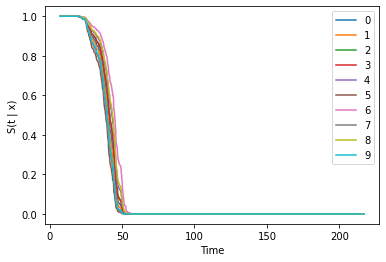

In [ ]:
surv.iloc[:, :10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')